In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error,make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import shap
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from plot_functions import *

import warnings
warnings.filterwarnings("ignore")

In [23]:
plt.rcParams["figure.dpi"] = 500

In [24]:
yld_df = pd.read_csv("Data/yield_model_data.csv").drop("Unnamed: 0", axis =1)
# irrig_df = pd.read_csv("Data/irrig_model_data.csv")
yld_df

,Reported_Yield,Year,FieldID,MinTemp_mean,MaxTemp_mean,GDD,NDVI,NDVI_Aug,ET_sum,vpd,Precip_sum,ReferenceET_sum,Tmp_excede33,Percent_Slope,Precip_deficit
0,12.428670,2016,NB1,6.106788,22.029015,1644.890021,0.651859,0.603531,676.170587,1.781269,544.150002,1139.259996,33,5.472,132.020586
1,10.184502,2017,NB1,5.822711,21.877106,1614.254973,0.660628,0.823997,648.051550,1.951652,535.800001,1148.359997,33,5.472,112.251549
2,13.101181,2018,NB1,4.975202,20.631099,1644.100009,0.714815,0.856244,696.440038,1.620673,443.960002,1130.510002,29,5.472,252.480036
3,8.171677,2020,NB1,5.105658,21.794927,1624.754994,0.587987,0.759675,656.890253,1.925848,331.310000,1218.569996,43,5.472,325.580253
4,10.247718,2021,NB1,5.365971,21.024176,1718.870071,0.660427,0.769854,630.049208,1.791752,438.000001,1166.679999,43,5.472,192.049207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,10.427278,2010,NW5,5.358873,21.483788,1678.094235,0.632124,0.848636,680.589186,1.811286,500.463421,1190.294696,47,4.025,180.125765
85,7.873083,2011,NW5,5.241023,23.079517,1703.116681,0.599659,0.809075,645.507771,2.356133,513.787253,1253.859250,65,4.025,131.720518
86,8.400331,2012,NW5,7.137018,25.398542,1742.358807,0.571647,0.599178,733.643316,2.941741,280.576171,1442.532989,65,4.025,453.067145
87,12.098467,2013,NW5,5.163082,22.073193,1677.740152,0.632650,0.847245,789.115758,2.253056,412.144595,1189.272089,52,4.025,376.971163


In [25]:
yld_df.describe()

,Reported_Yield,Year,MinTemp_mean,MaxTemp_mean,GDD,NDVI,NDVI_Aug,ET_sum,vpd,Precip_sum,ReferenceET_sum,Tmp_excede33,Percent_Slope,Precip_deficit
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,11.558373,2015.539326,5.479933,21.954169,1663.017055,0.652910,0.810793,702.443985,1.931508,462.087980,1189.439445,41.797753,4.093337,240.356005
std,2.732363,4.290730,0.848627,1.257537,70.488590,0.067188,0.082561,51.870033,0.386805,111.843583,96.504577,13.356289,0.789117,131.164211
min,4.621493,2008.000000,4.229268,19.945606,1475.545154,0.514084,0.523538,570.474861,1.259735,247.429999,1020.008096,14.000000,2.416000,-25.113995
25%,10.068158,2012.000000,5.000183,21.045244,1623.149896,0.606542,0.807752,671.172069,1.684590,394.000001,1148.359997,32.000000,3.796000,136.927910
50%,12.074257,2016.000000,5.253383,21.877106,1675.893091,0.649018,0.843348,694.631879,1.819380,489.789186,1165.082234,43.000000,4.025000,236.800576
75%,13.296209,2019.000000,5.895191,22.367288,1704.757703,0.712067,0.859017,741.531424,2.210737,538.040242,1218.166020,49.000000,4.866000,320.343176
max,18.527670,2022.000000,7.920596,25.406386,1851.952304,0.822295,0.892537,829.937171,2.941741,652.299996,1445.517576,65.000000,5.472000,523.730026


### XGBoost model random split- hyperparameter tuning

In [26]:
X_xgb = yld_df.iloc[:,3:] #independent variables
Y_xgb = yld_df["Reported_Yield"] # target


X_train, X_test, y_train, y_test = train_test_split(X_xgb, Y_xgb, test_size=0.2, random_state=153)

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# hyperparameters

# param_grid = {
#     'n_estimators': [ 50,100, 200,500],
#     'max_depth': [ 2,3,5],
#     'learning_rate': [ 0.1,.2],
#     'subsample': [.8, 0.9],
#     'colsample_bytree': [  .5, .8, .9],
#     'gamma': [ .2, .4, .5,.6],
#     "reg_alpha": [.1,.2,.3]
# }

# now best params found
param_grid = {
    'n_estimators': [50],
    'max_depth': [2],
    'learning_rate': [0.2],
    'subsample': [0.9],
    'colsample_bytree': [0.7],
    'gamma': [0.6],
    'reg_alpha': [0.4]
}


# Define the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()


# Perform grid search with 10-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring=mae_scorer, cv=5, n_jobs=8)
grid_search.fit(X_train, y_train)



# # # Print the best parameters
best_params_xgb = grid_search.best_params_
print(f'Best Parameters for XGBoost: {best_params_xgb}')

# # Train the XGBoost model with the best parameters
best_yld_xgb_model = xgb.XGBRegressor(**best_params_xgb)
best_yld_xgb_model.fit(X_train, y_train)



y_pred_xgb = best_yld_xgb_model.predict(X_test)
y_pred_train_xgb = best_yld_xgb_model.predict(X_train)

# Calculate and print the Mean Absolute Error on the test set
mae_test_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f'Mean Absolute Error on Test Set (XGBoost): {mae_test_xgb}')

# Calculate and print R2 score on the test set
r2_test_xgb = r2_score(y_test, y_pred_xgb)
print(f'R2 Score on Test Set (XGBoost): {r2_test_xgb:.4f}')


mae_train_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
print(f'Mean Absolute Error on Training Set (XGBoost): {mae_train_xgb}')

# Calculate and print R2 score on the training set
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)
print(f'R2 Score on Training Set (XGBoost): {r2_train_xgb:.4f}')




Best Parameters for XGBoost: {'colsample_bytree': 0.7, 'gamma': 0.6, 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50, 'reg_alpha': 0.4, 'subsample': 0.9}
Mean Absolute Error on Test Set (XGBoost): 0.7133076954064399
R2 Score on Test Set (XGBoost): 0.8872
Mean Absolute Error on Training Set (XGBoost): 0.4247421581273794
R2 Score on Training Set (XGBoost): 0.9593


### in a single random split finding best rendom state/split

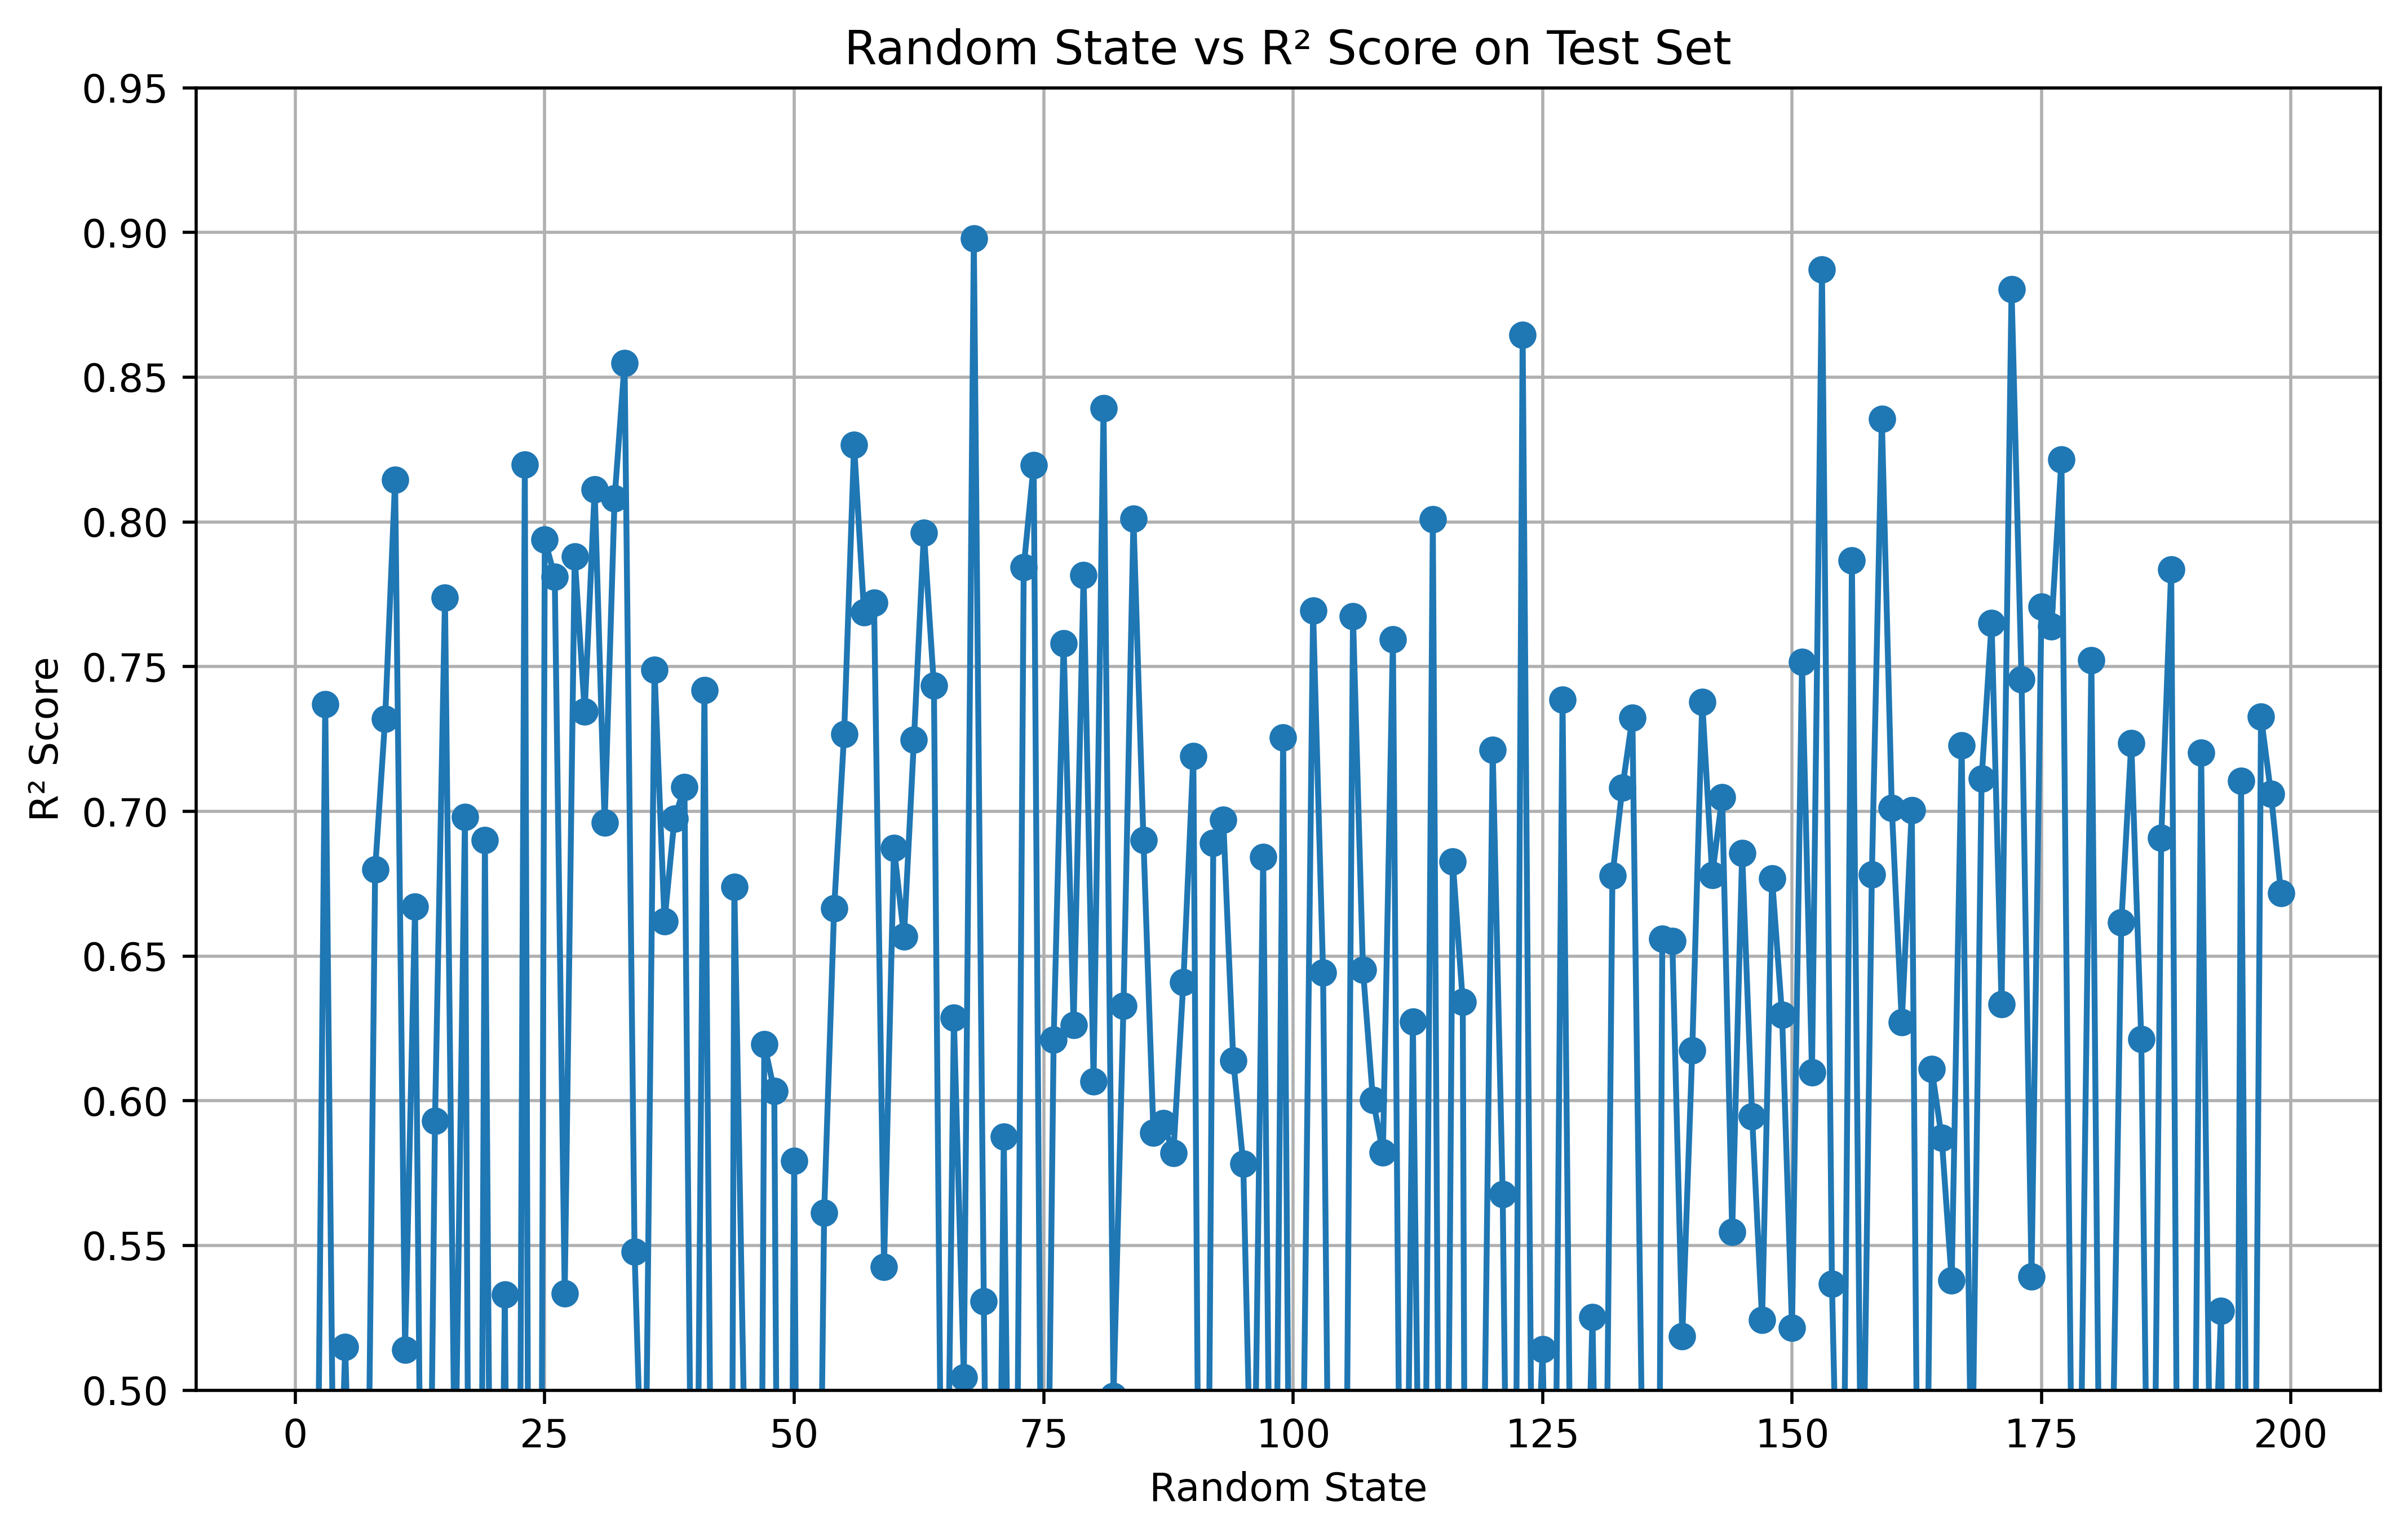

In [27]:
random_states = []
r2_scores = []

# Loop over 100 random states
for random_state in range(0, 200):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_xgb, Y_xgb, test_size=0.2, random_state=random_state)
    
    # Grid search
    grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring=mae_scorer, cv=5, n_jobs=8)
    grid_search.fit(X_train, y_train)
    
    best_params_xgb = grid_search.best_params_
    
    # Train best model
    best_yld_xgb_model = xgb.XGBRegressor(**best_params_xgb)
    best_yld_xgb_model.fit(X_train, y_train)
    
    # Predict and calculate R2 on test set
    y_pred_xgb = best_yld_xgb_model.predict(X_test)
    r2_test_xgb = r2_score(y_test, y_pred_xgb)
    mae_test_xgb = mean_absolute_error(y_test, y_pred_xgb)
    
    # Store results
    random_states.append(random_state)
    r2_scores.append(r2_test_xgb)

# Plotting Random State vs R2
plt.figure(figsize=(10, 6))
plt.plot(random_states, r2_scores, marker='o')
plt.xlabel('Random State')
plt.ylim(.5,.95)
plt.ylabel('R² Score')
plt.title('Random State vs R² Score on Test Set')
plt.grid(True)
plt.show()


In [28]:
# Convert to numpy array (if not already)
r2_scores_array = np.array(r2_scores)

# Get indices of top 5 highest R2 scores
top5_indices = np.argsort(r2_scores_array)[-5:][::-1]  # sort, pick last 5, then reverse

# Get the corresponding random states and R2 values
top5_random_states = [random_states[i] for i in top5_indices]
top5_r2_scores = [r2_scores[i] for i in top5_indices]

# Print them
for rs, r2 in zip(top5_random_states, top5_r2_scores):
    print(f'Random State: {rs}, R² Score: {r2:.4f}')

Random State: 68, R² Score: 0.8978
Random State: 153, R² Score: 0.8872
Random State: 172, R² Score: 0.8803
Random State: 123, R² Score: 0.8645
Random State: 33, R² Score: 0.8549


## 5 Random CV

In [29]:

def run_xgb_kfold(X, y, n_splits=5, random_state=153, params=None):
    """
    Run XGBoost regression with KFold CV.
    
    Returns:
        results_df: DataFrame with columns:
                    ['Fold', 'Set', 'Actual', 'Predicted']
        metrics_df: DataFrame with MAE and R2 per fold
    """
    if params is None:
        params = {
            'n_estimators': 50,
            'max_depth': 2,
            'learning_rate': 0.2,
            'subsample': 0.9,
            'colsample_bytree': 0.7,
            'gamma': 0.6,
            'reg_alpha': 0.4,
            'random_state': random_state
        }

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    results = []
    metrics = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit model
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Save results
        results.extend([
            pd.DataFrame({
                'Fold': fold,
                'Set': 'Train',
                'Actual': y_train,
                'Predicted': y_train_pred
            }),
            pd.DataFrame({
                'Fold': fold,
                'Set': 'Test',
                'Actual': y_test,
                'Predicted': y_test_pred
            })
        ])

        # Save metrics
        metrics.append({
            'Fold': fold,
            'Train_MAE': mean_absolute_error(y_train, y_train_pred),
            'Test_MAE': mean_absolute_error(y_test, y_test_pred),
            'Train_R2': r2_score(y_train, y_train_pred),
            'Test_R2': r2_score(y_test, y_test_pred)
        })

    results_df = pd.concat(results, ignore_index=True)
    metrics_df = pd.DataFrame(metrics)
    return results_df, metrics_df




In [30]:
X_xgb = yld_df.iloc[:,3:]
Y_xgb = yld_df["Reported_Yield"]
results_df, metrics_df = run_xgb_kfold(X_xgb, Y_xgb)
results_df

,Fold,Set,Actual,Predicted
0,1,Train,12.428670,11.932896
1,1,Train,10.184502,10.284702
2,1,Train,13.101181,13.544265
3,1,Train,8.171677,8.050550
4,1,Train,10.247718,9.760721
...,...,...,...,...
440,5,Test,12.138146,10.484765
441,5,Test,6.129935,9.225837
442,5,Test,11.550371,11.585516
443,5,Test,12.074257,11.198233


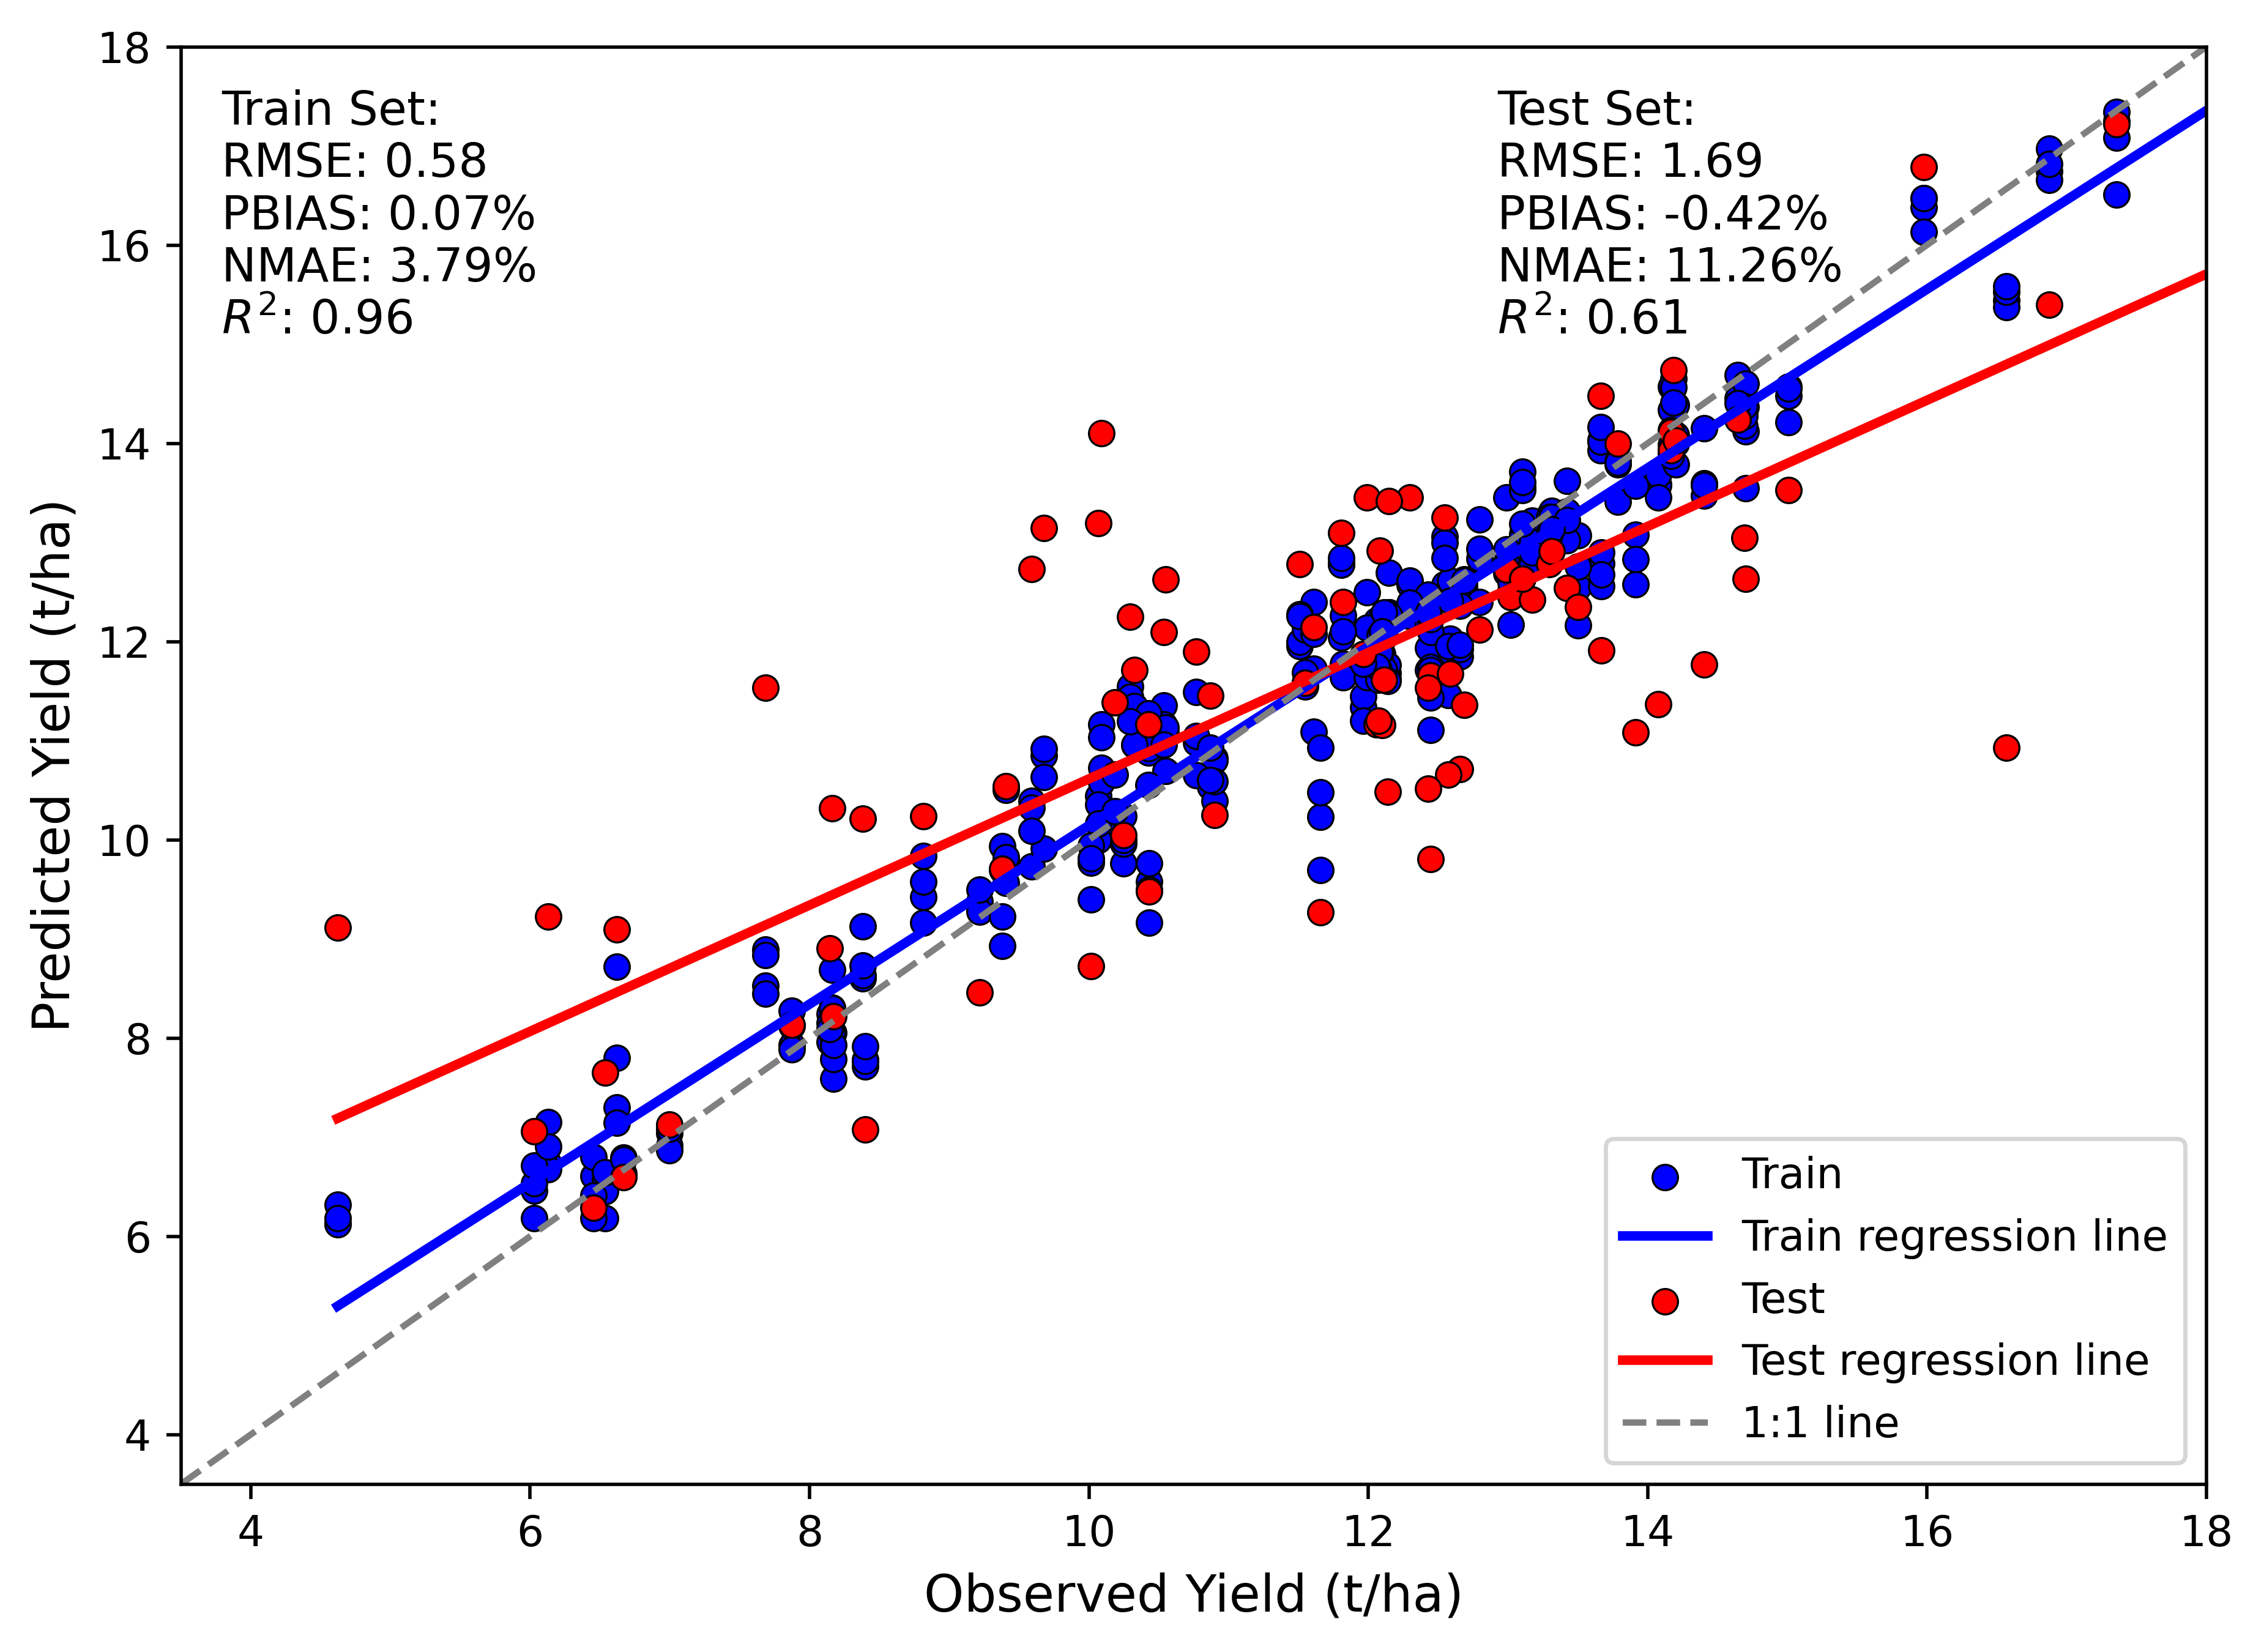

In [31]:
evaluate_model(
    y_train=results_df.loc[results_df["Set"] == "Train", "Actual"],
    y_pred_train=results_df.loc[results_df["Set"] == "Train", "Predicted"],
    y_test = results_df.loc[results_df["Set"] == "Test", "Actual"],
    y_pred_test = results_df.loc[results_df["Set"] == "Test", "Predicted"],
    units='t/ha',
    text = "Test Set",
    label = "",
#     hue =results_df["Fold"],
    xlabel = "Observed Yield", ylabel = "Predicted Yield",
    p= .50,
    legend_outside=False
)


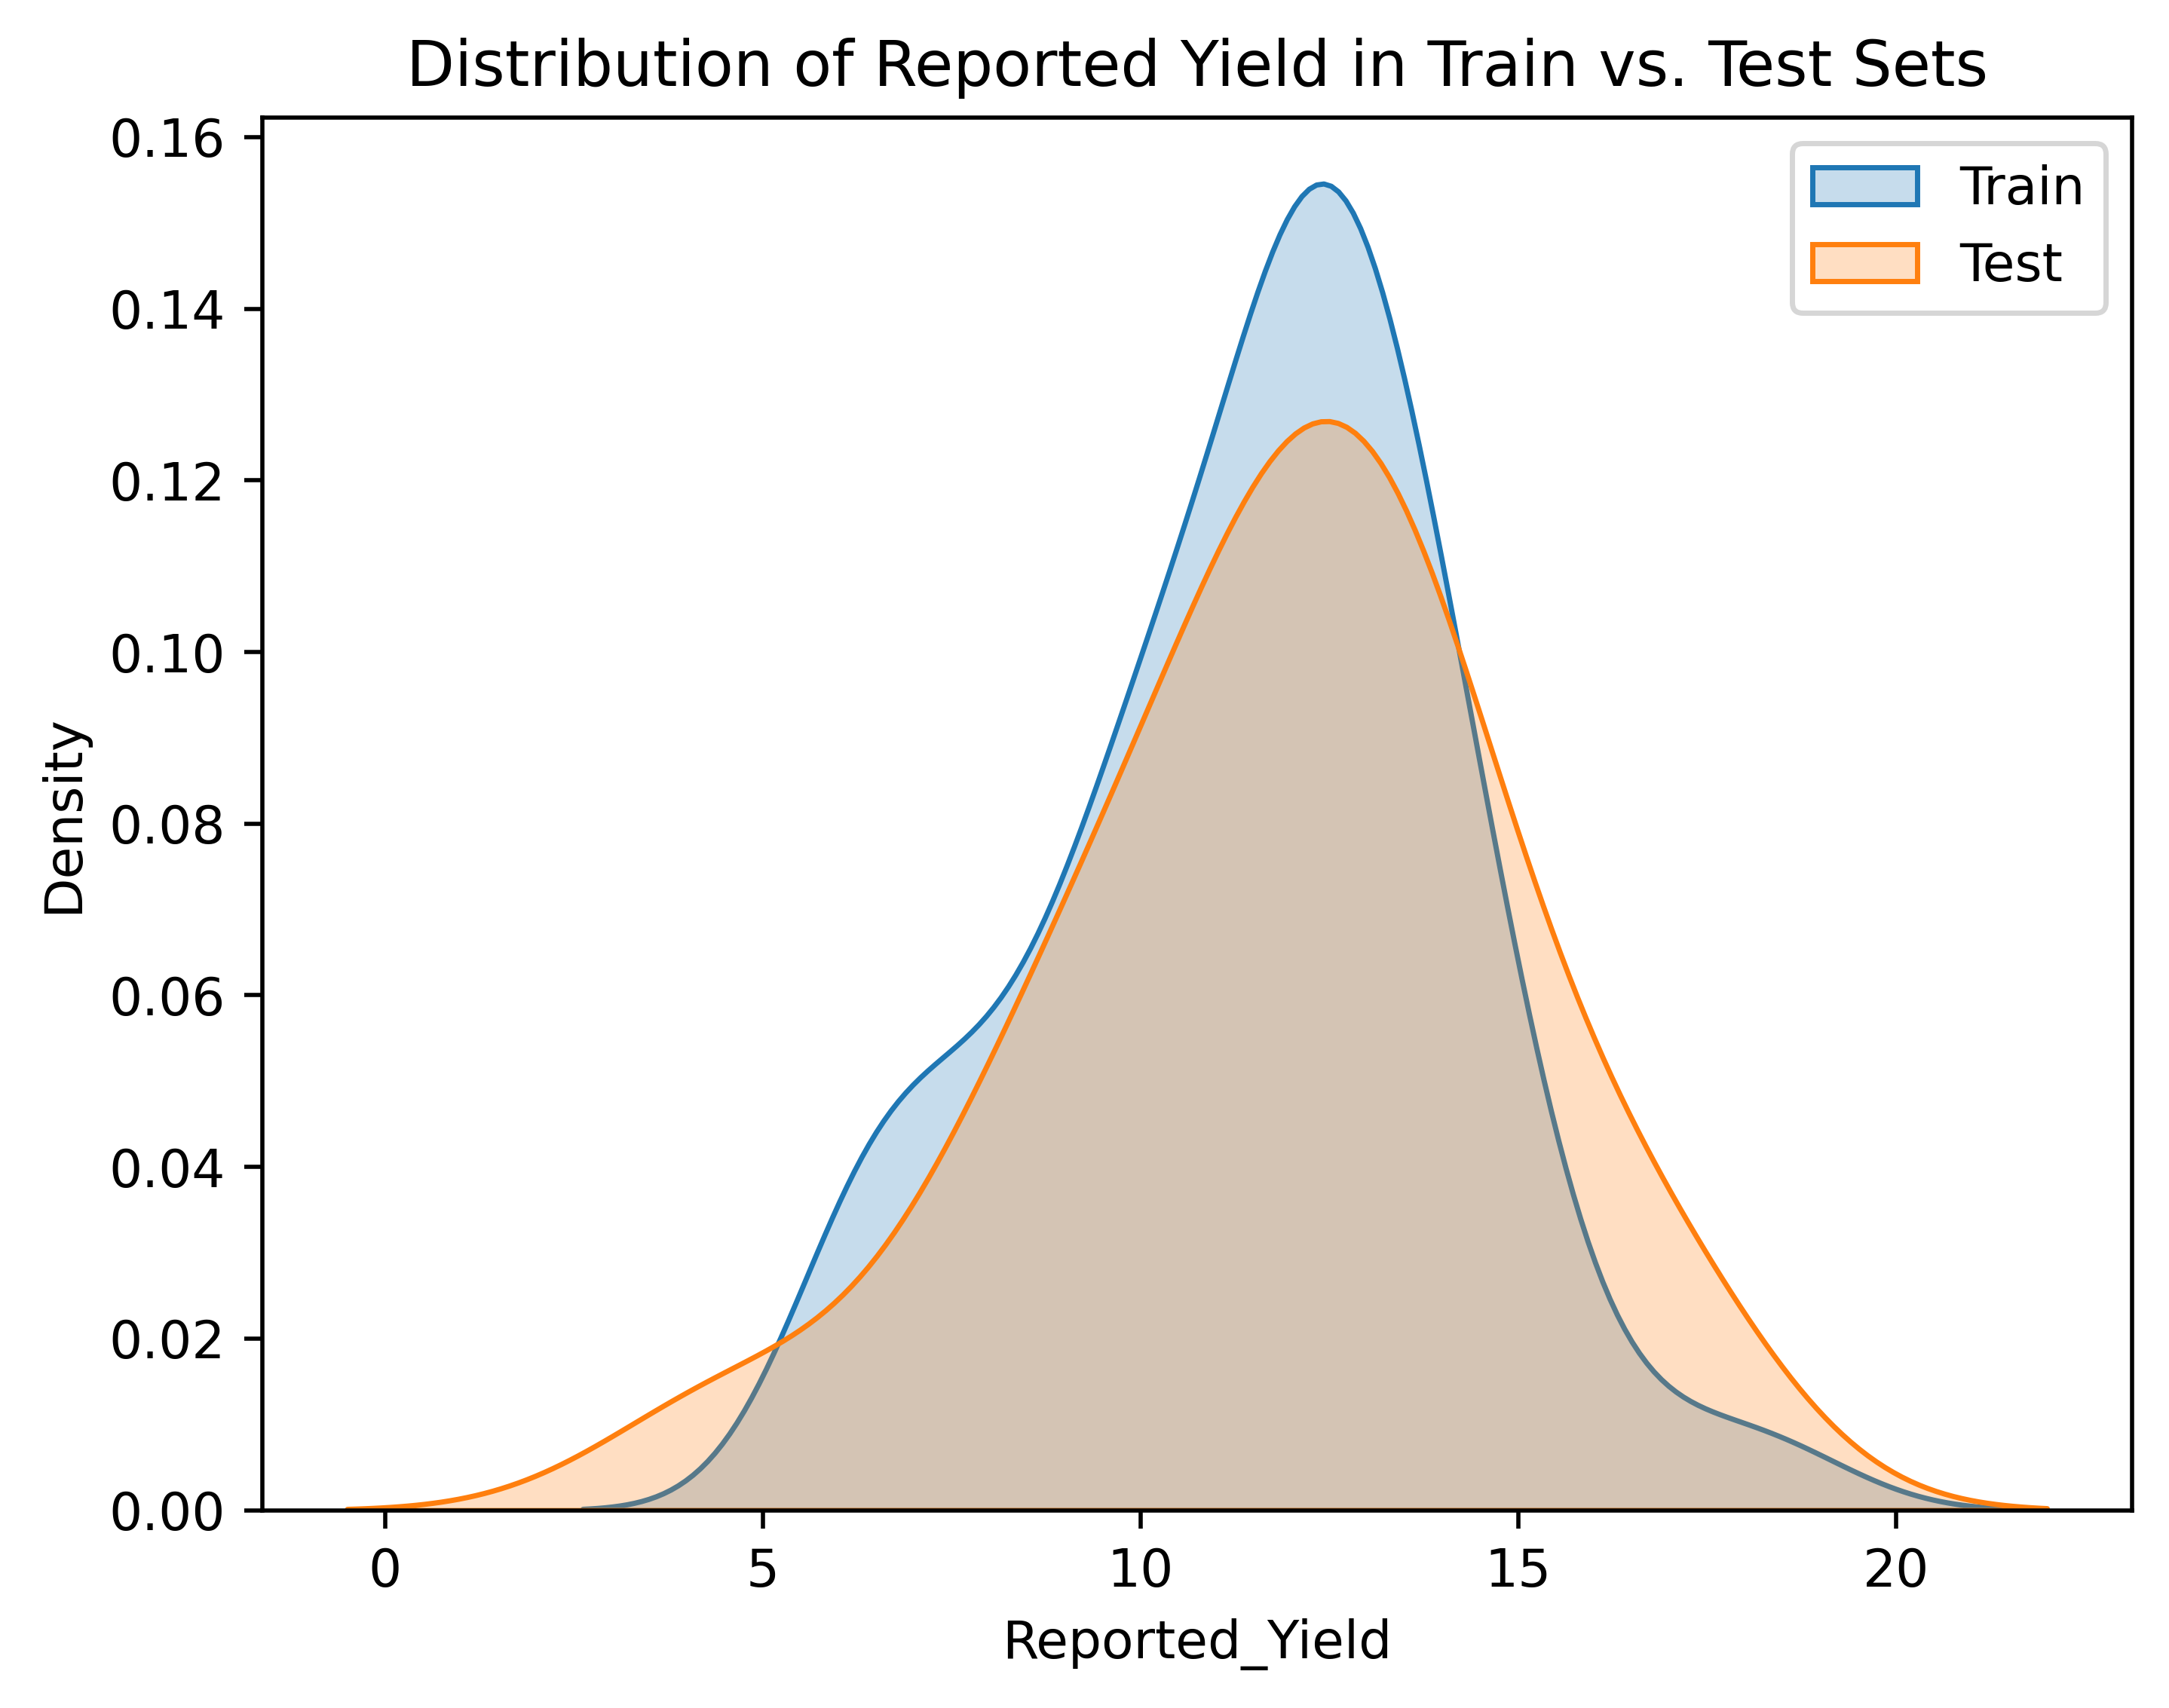

In [36]:
sns.kdeplot(y_train, label="Train", shade=True)
sns.kdeplot(y_test, label="Test", shade=True)
plt.legend()
plt.title("Distribution of Reported Yield in Train vs. Test Sets")
plt.show()

### feature importance

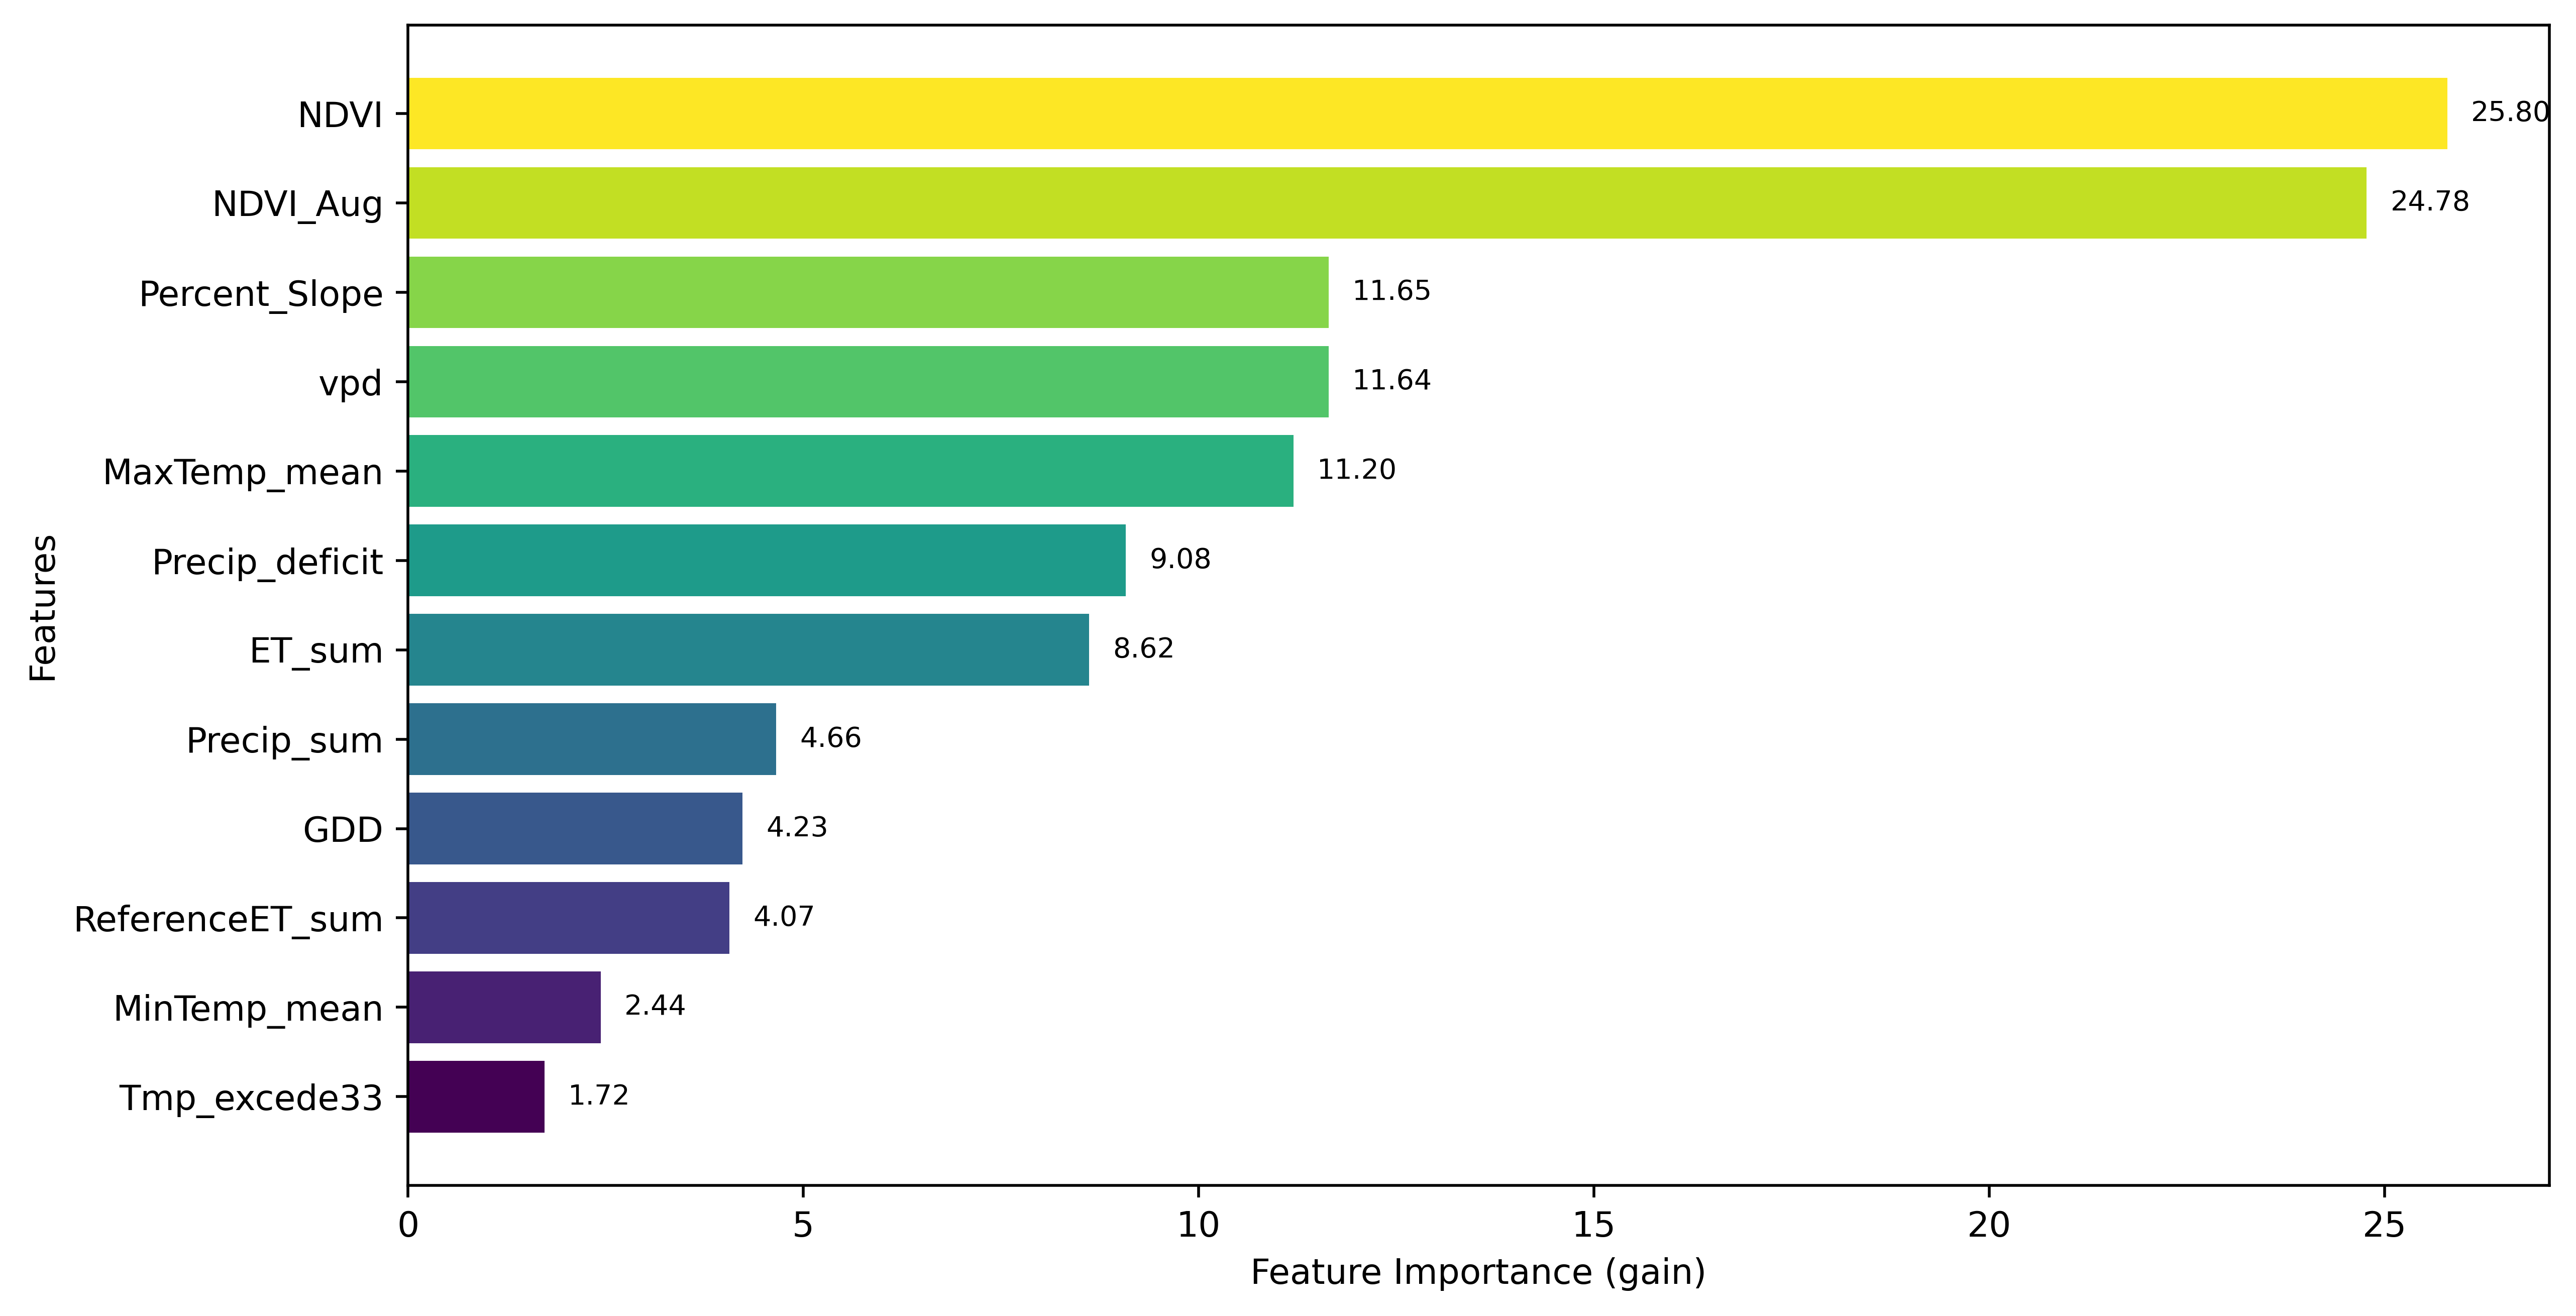

In [35]:
feature_importance_gain = best_yld_xgb_model.get_booster().get_score(importance_type="gain")
sorted_feature_importance_gain = sorted(feature_importance_gain.items(), key=lambda x: x[1], reverse=False)
# Extract feature names and gain scores
feature_names_gain = [x[0] for x in sorted_feature_importance_gain]
gain_scores = [x[1] for x in sorted_feature_importance_gain]

# Define a colormap
num_features = len(feature_names_gain)
cmap = plt.cm.get_cmap(None, num_features)

# Create a bar plot of feature importance (gain) with custom colors
plt.figure(figsize=(11, 6))
bars = plt.barh(feature_names_gain, gain_scores, color=[cmap(i) for i in range(num_features)])
plt.xlabel('Feature Importance (gain)')
plt.ylabel('Features')

# Add annotations for values at the end of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_width()+.3, bar.get_y() + bar.get_height()/2, f'{gain_scores[i]:.2f}',
             va='center', ha='left', fontsize=8)

plt.show()

we use We use 
𝑋test (or X_importance = X_test) for SHAP analysis because we want to interpret how the model 
makes predictions (do the scoring on unseen data) on unseen data. 
![image.png](attachment:image.png)

![image-2.png](attachment:image-2.png)
![image-3.png](attachment:image-3.png)